# Waste Classification System

**ResNet50V2 Deep Learning for Recyclable vs Non-Recyclable Waste Detection**

This notebook implements a modern waste classification system using ResNet50V2 optimized for Google Colab with GPU acceleration and TensorFlow 2.19.

## Features:
- **GPU Optimized** for Google Colab
- **ResNet50V2 Model** (Modern TensorFlow 2.19 optimized)
- **Comprehensive Analysis** with visualizations
- **Mobile Export** (TensorFlow Lite)
- **Data Augmentation** for better generalization
- **Real-time Monitoring** of training progress
- **Modern TensorFlow** practices (SavedModel format, no legacy .h5)


## 1. Setup and Installation


In [14]:
!pip install kagglehub tensorflow matplotlib seaborn scikit-learn pillow opencv-python

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPU detected")


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled


## 2. Mount Google Drive and Setup


In [15]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import kagglehub
from PIL import Image
import cv2
import warnings
import json
import zipfile
from datetime import datetime
import tempfile
import shutil

warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
print("Google Drive mounted successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All libraries imported successfully
TensorFlow version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Google Drive mounted successfully


## 3. Load Project Files from Google Drive

### Step 1: Upload Project Files to Google Drive

1. Create a folder called `waste-bin` in your Google Drive
2. Upload these files to that folder:
   - `waste_classifier.py`
   - `training_utils.py`
   - `requirements.txt`
   - `README.md`

### Step 2: Load Files in Colab

The code below will load the files from your Google Drive.


In [16]:

PROJECT_PATH = '/content/drive/MyDrive/wastebin'

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

required_files = ['waste_classifier.py', 'training_utils.py']
missing_files = []

for file in required_files:
    file_path = os.path.join(PROJECT_PATH, file)
    if not os.path.exists(file_path):
        missing_files.append(file)

if missing_files:
    print(f"Missing files: {missing_files}")
    print(f"Please upload the following files to: {PROJECT_PATH}")
    print("Required files:")
    for file in required_files:
        print(f"  - {file}")
    print("\nAlternatively, you can upload them directly to Colab:")
    from google.colab import files
    uploaded = files.upload()
else:
    print("All project files found in Google Drive")

try:
    from waste_classifier import MultiModelWasteClassifier
    from training_utils import (
        analyze_dataset_balance,
        create_sample_predictions_demo,
        quick_train_best_models,
        comprehensive_train_all_models,
        main_quick,
        main_comprehensive,
        main_custom
    )
    print("Project modules imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure the files are in the correct location or upload them directly to Colab")


All project files found in Google Drive
Project modules imported successfully


### Alternative: Direct Upload to Colab

If you prefer to upload files directly to Colab instead of using Google Drive, uncomment and run the cell below:


In [17]:
# Alternative: Direct upload to Colab (uncomment if not using Google Drive)
# from google.colab import files
# uploaded = files.upload()
# print("Files uploaded:", list(uploaded.keys()))

print("Using Google Drive method (recommended)")


Using Google Drive method (recommended)


## 4. Dataset Download using KaggleHub

Using the intuitive kagglehub approach to download the dataset directly.


In [18]:
import kagglehub

print("Downloading dataset using kagglehub...")
print("This will download the latest version of the dataset")

path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Dataset downloaded successfully!")
print(f"Path to dataset files: {path}")

if os.path.exists(path):
    print(f"\nDataset contents:")
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            total_images = 0
            for subdir in ['default', 'real_world']:
                subdir_path = os.path.join(item_path, subdir)
                if os.path.exists(subdir_path):
                    images = [f for f in os.listdir(subdir_path)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                    total_images += len(images)
            print(f"  {item}: {total_images} images")
else:
    print("Dataset not found at the expected location")


This will download the latest version of the dataset
Using Colab cache for faster access to the 'recyclable-and-household-waste-classification' dataset.
Dataset downloaded successfully!
Path to dataset files: /kaggle/input/recyclable-and-household-waste-classification

Dataset contents:
  images: 0 images


In [19]:
dataset_path = path

print(f"Dataset path set to: {dataset_path}")
print("Ready to start training!")


Dataset path set to: /kaggle/input/recyclable-and-household-waste-classification
Ready to start training!


## 5. Quick Training (Recommended)

This will train ResNet50V2 only - optimized for modern TensorFlow 2.19


This will download the latest version of the dataset
Using Colab cache for faster access to the 'recyclable-and-household-waste-classification' dataset.
Dataset downloaded successfully!
Path to dataset files: /kaggle/input/recyclable-and-household-waste-classification
Found dataset structure at: /kaggle/input/recyclable-and-household-waste-classification/images/images

Scanning categories in: /kaggle/input/recyclable-and-household-waste-classification/images/images
  aerosol_cans: 250 default + 250 real_world = 500 total
  aluminum_food_cans: 250 default + 250 real_world = 500 total
  aluminum_soda_cans: 250 default + 250 real_world = 500 total
  cardboard_boxes: 250 default + 250 real_world = 500 total
  cardboard_packaging: 250 default + 250 real_world = 500 total
  clothing: 250 default + 250 real_world = 500 total
  coffee_grounds: 250 default + 250 real_world = 500 total
  disposable_plastic_cutlery: 250 default + 250 real_world = 500 total
  eggshells: 250 default + 250 real_worl

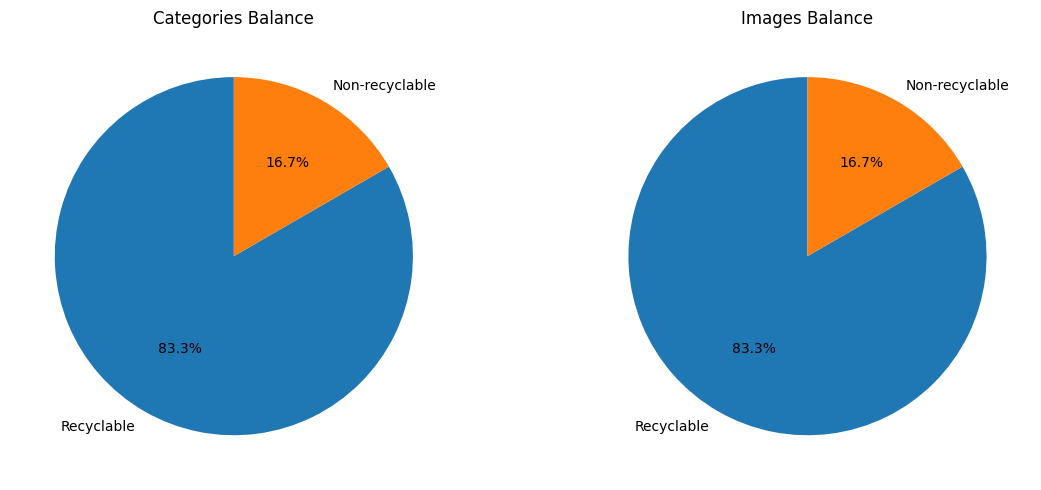

Preparing data generators...
Processing hierarchical dataset structure (default + real_world)
Organizing data for binary classification...
   plastic_soda_bottles (recyclable): 500 images
   aerosol_cans (recyclable): 500 images
   steel_food_cans (recyclable): 500 images
   disposable_plastic_cutlery (recyclable): 500 images
   cardboard_boxes (recyclable): 500 images
   glass_beverage_bottles (recyclable): 500 images
   plastic_cup_lids (recyclable): 500 images
   plastic_straws (non_recyclable): 500 images
   plastic_shopping_bags (recyclable): 500 images
   styrofoam_cups (recyclable): 500 images
   cardboard_packaging (recyclable): 500 images
   glass_food_jars (recyclable): 500 images
   styrofoam_food_containers (recyclable): 500 images
   eggshells (non_recyclable): 500 images
   aluminum_food_cans (recyclable): 500 images
   coffee_grounds (recyclable): 500 images
   plastic_food_containers (recyclable): 500 images
   food_waste (recyclable): 500 images
   magazines (recyclabl

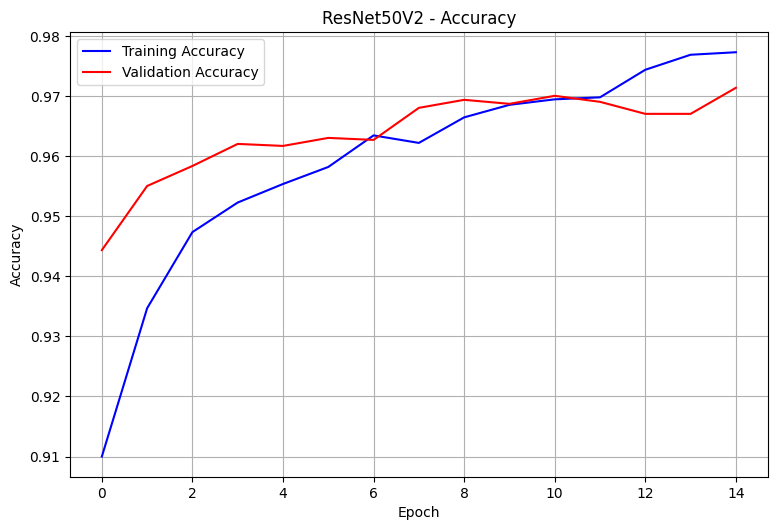

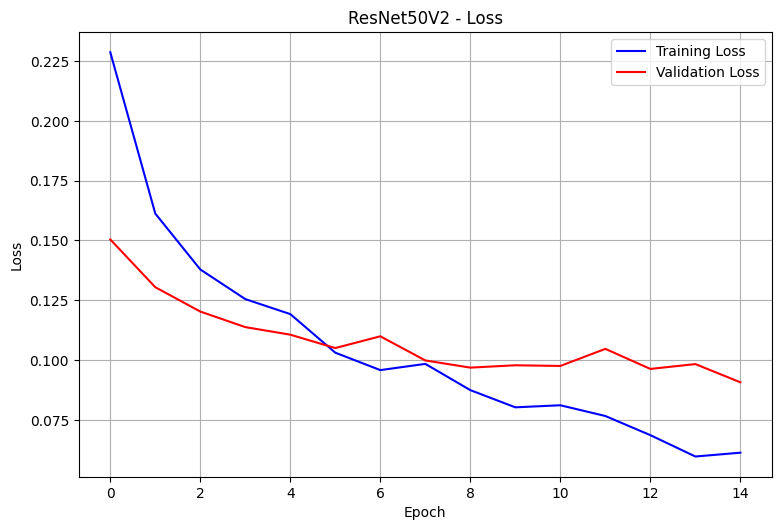


🔍 SAMPLE PREDICTIONS DEMO
----------------------------------------


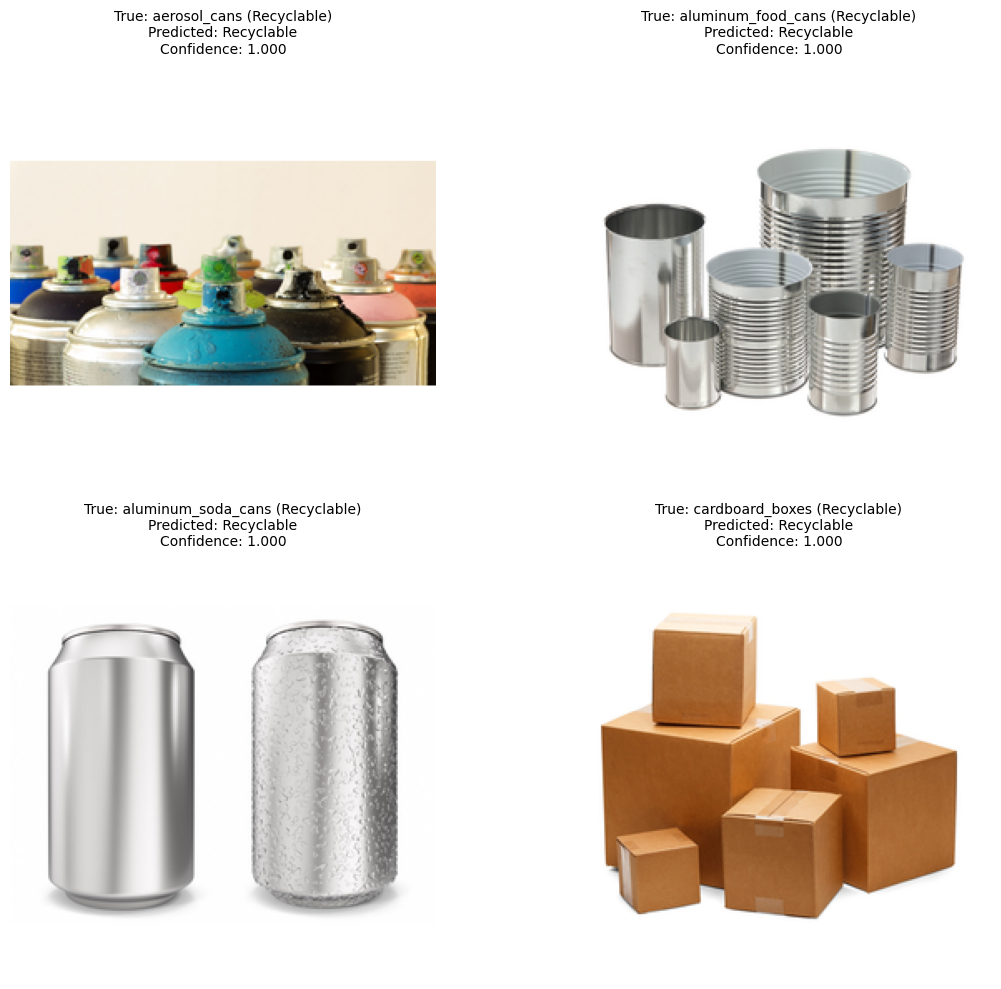


Creating deployment package...
Model saved: /content/drive/MyDrive/WasteClassifierModels/best_model.keras
Deployment info saved: /content/drive/MyDrive/WasteClassifierModels/deployment_info.json
Deployment package ready!

MOBILE EXPORT
Exporting ResNet50V2 for mobile deployment...
Error during mobile export: this __dict__ descriptor does not support '_DictWrapper' objects

 Training completed! Best model: ResNet50V2
Best accuracy: 0.9713


In [20]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

print("Downloading dataset using kagglehub...")
print("This will download the latest version of the dataset")

path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
print("Dataset downloaded successfully!")
print(f"Path to dataset files: {path}")

def find_dataset_structure(base_path):
    """Find the correct dataset structure by checking multiple possible paths"""
    possible_paths = [
        os.path.join(base_path, "images", "images"),
        os.path.join(base_path, "images"),
        base_path
    ]

    for test_path in possible_paths:
        if os.path.exists(test_path):

            items = [item for item in os.listdir(test_path)
                    if os.path.isdir(os.path.join(test_path, item))]

            if items:
                for item in items[:3]:
                    item_path = os.path.join(test_path, item)
                    has_default = os.path.exists(os.path.join(item_path, "default"))
                    has_real_world = os.path.exists(os.path.join(item_path, "real_world"))

                    if has_default or has_real_world:
                        print(f"Found dataset structure at: {test_path}")
                        return test_path

    print(f"No valid dataset structure found in any of: {possible_paths}")
    return None

def get_waste_categories(images_path):
    """Get the actual waste categories from the dataset structure"""
    categories = []
    category_info = {}

    if not os.path.exists(images_path):
        print(f"Images path not found: {images_path}")
        return [], {}

    print(f"\nScanning categories in: {images_path}")

    for item in sorted(os.listdir(images_path)):
        item_path = os.path.join(images_path, item)

        if os.path.isdir(item_path):
            default_path = os.path.join(item_path, "default")
            real_world_path = os.path.join(item_path, "real_world")

            default_count = 0
            real_world_count = 0

            if os.path.exists(default_path):
                default_images = [f for f in os.listdir(default_path)
                                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                default_count = len(default_images)

            if os.path.exists(real_world_path):
                real_world_images = [f for f in os.listdir(real_world_path)
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                real_world_count = len(real_world_images)

            total_images = default_count + real_world_count

            if total_images > 0:
                categories.append(item)
                category_info[item] = {
                    'default': default_count,
                    'real_world': real_world_count,
                    'total': total_images
                }
                print(f"  {item}: {default_count} default + {real_world_count} real_world = {total_images} total")

    return categories, category_info

def analyze_dataset_balance(dataset_path, label_mapping):
    """Analyze the balance of recyclable vs non-recyclable items"""
    print("\n DATASET BALANCE ANALYSIS")
    print("-" * 40)

    recyclable_count = 0
    non_recyclable_count = 0
    recyclable_images = 0
    non_recyclable_images = 0

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path) or category not in label_mapping:
            continue

        total_images = 0
        for subdir in ['default', 'real_world']:
            subdir_path = os.path.join(category_path, subdir)
            if os.path.exists(subdir_path):
                images = [f for f in os.listdir(subdir_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                total_images += len(images)

        if label_mapping[category] == 1:
            recyclable_count += 1
            recyclable_images += total_images
        else:
            non_recyclable_count += 1
            non_recyclable_images += total_images

    total_categories = recyclable_count + non_recyclable_count
    total_images = recyclable_images + non_recyclable_images

    print(f"Categories:")
    print(f"  Recyclable: {recyclable_count} ({recyclable_count/total_categories*100:.1f}%)")
    print(f"  Non-recyclable: {non_recyclable_count} ({non_recyclable_count/total_categories*100:.1f}%)")
    print(f"\nImages:")
    print(f"  Recyclable: {recyclable_images:,} ({recyclable_images/total_images*100:.1f}%)")
    print(f"  Non-recyclable: {non_recyclable_images:,} ({non_recyclable_images/total_images*100:.1f}%)")
    print(f"  Total: {total_images:,}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.pie([recyclable_count, non_recyclable_count],
            labels=['Recyclable', 'Non-recyclable'],
            autopct='%1.1f%%', startangle=90)
    ax1.set_title('Categories Balance')

    ax2.pie([recyclable_images, non_recyclable_images],
            labels=['Recyclable', 'Non-recyclable'],
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Images Balance')

    plt.tight_layout()
    plt.show()

def quick_train_best_models(classifier, train_gen, val_gen):
    """Train only the best performing models for quick results"""
    print("\n🚀 QUICK TRAINING - ResNet50V2")
    print("-" * 40)

    selected_models = ['ResNet50V2']
    best_model_name = classifier.train_all_models(train_gen, val_gen, selected_models)

    return best_model_name

def create_sample_predictions_demo(classifier, dataset_path, label_mapping):
    """Create a demo showing sample predictions"""
    if not classifier.best_model:
        print("No trained model available for demo")
        return

    print("\n🔍 SAMPLE PREDICTIONS DEMO")
    print("-" * 40)

    sample_images = []
    sample_labels = []

    for category in list(label_mapping.keys())[:4]:
        category_path = os.path.join(dataset_path, category)

        for subdir in ['default', 'real_world']:
            subdir_path = os.path.join(category_path, subdir)
            if os.path.exists(subdir_path):
                images = [f for f in os.listdir(subdir_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                if images:
                    sample_path = os.path.join(subdir_path, images[0])
                    sample_images.append(sample_path)
                    sample_labels.append(f"{category} ({'Recyclable' if label_mapping[category] == 1 else 'Non-recyclable'})")
                    break

    if not sample_images:
        print("No sample images found for demo")
        return

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (img_path, true_label) in enumerate(zip(sample_images, sample_labels)):
        if i >= 4:
            break

        try:

            result = classifier.predict_image(img_path)

            if result:
                from PIL import Image
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].axis('off')

                pred_text = f"True: {true_label}\nPredicted: {result['prediction']}\nConfidence: {result['confidence']:.3f}"
                axes[i].set_title(pred_text, fontsize=10)
            else:
                axes[i].text(0.5, 0.5, 'Prediction failed', ha='center', va='center')
                axes[i].set_title(true_label)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            axes[i].text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center')
            axes[i].set_title(true_label)

    for i in range(len(sample_images), 4):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    images_base_path = find_dataset_structure(path)

    if not images_base_path:
        print("Could not find valid dataset structure")
        print("Please check the downloaded dataset manually")
        exit(1)

    categories, category_info = get_waste_categories(images_base_path)

    print(f"\nFound {len(categories)} waste categories:")
    total_images = sum(info['total'] for info in category_info.values())
    print(f"Total images across all categories: {total_images}")

    if categories and total_images > 0:

        try:
            classifier = MultiModelWasteClassifier(dataset_path=images_base_path)

            print("Using actual waste categories...")
            print(f"Categories: {categories[:5]}..." if len(categories) > 5 else f"Categories: {categories}")

            label_mapping = classifier.create_binary_labels(categories)

            print(f"\nBinary Classification Mapping:")
            recyclable_count = sum(1 for label in label_mapping.values() if label == 1)
            non_recyclable_count = len(label_mapping) - recyclable_count
            print(f"Recyclable categories: {recyclable_count}")
            print(f"Non-recyclable categories: {non_recyclable_count}")

            analyze_dataset_balance(images_base_path, label_mapping)

            train_gen, val_gen, temp_dir = classifier.prepare_data_generators(images_base_path, label_mapping)

            best_model = quick_train_best_models(classifier, train_gen, val_gen)

            classifier.plot_training_histories()

            create_sample_predictions_demo(classifier, images_base_path, label_mapping)

            classifier.create_deployment_package()

            classifier.export_for_mobile()

            import shutil
            if 'temp_dir' in locals():
                shutil.rmtree(temp_dir, ignore_errors=True)

            print(f"\n Training completed! Best model: {best_model}")
            if classifier.results and classifier.best_model_name:
                print(f"Best accuracy: {classifier.results[classifier.best_model_name]['val_accuracy']:.4f}")

        except NameError:
            print("MultiModelWasteClassifier not found. Please run the fixed classifier code first.")
        except Exception as e:
            print(f"Error during training: {e}")
            import traceback
            traceback.print_exc()

    else:
        print("No valid waste categories found. Please check the dataset structure.")
        print(f"Expected structure: [category_name]/[default|real_world]/[image_files]")

## 6. Model Export and Download

Export the trained model for deployment


In [21]:
if 'classifier' in locals() and classifier.best_model:
    print("Creating deployment package...")
    classifier.create_deployment_package()

    print("\nExporting for mobile deployment...")
    tflite_path = classifier.export_for_mobile()

    if tflite_path:
        print(f"Mobile model exported: {tflite_path}")

        from google.colab import files
        files.download(tflite_path)

        info_path = os.path.join(classifier.save_dir, 'deployment_info.json')
        if os.path.exists(info_path):
            files.download(info_path)
else:
    print("No trained model available for export")


Creating deployment package...

Creating deployment package...
Model saved: /content/drive/MyDrive/WasteClassifierModels/best_model.keras
Deployment info saved: /content/drive/MyDrive/WasteClassifierModels/deployment_info.json
Deployment package ready!

Exporting for mobile deployment...

MOBILE EXPORT
Exporting ResNet50V2 for mobile deployment...
Error during mobile export: this __dict__ descriptor does not support '_DictWrapper' objects
